/home/m/m300872/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


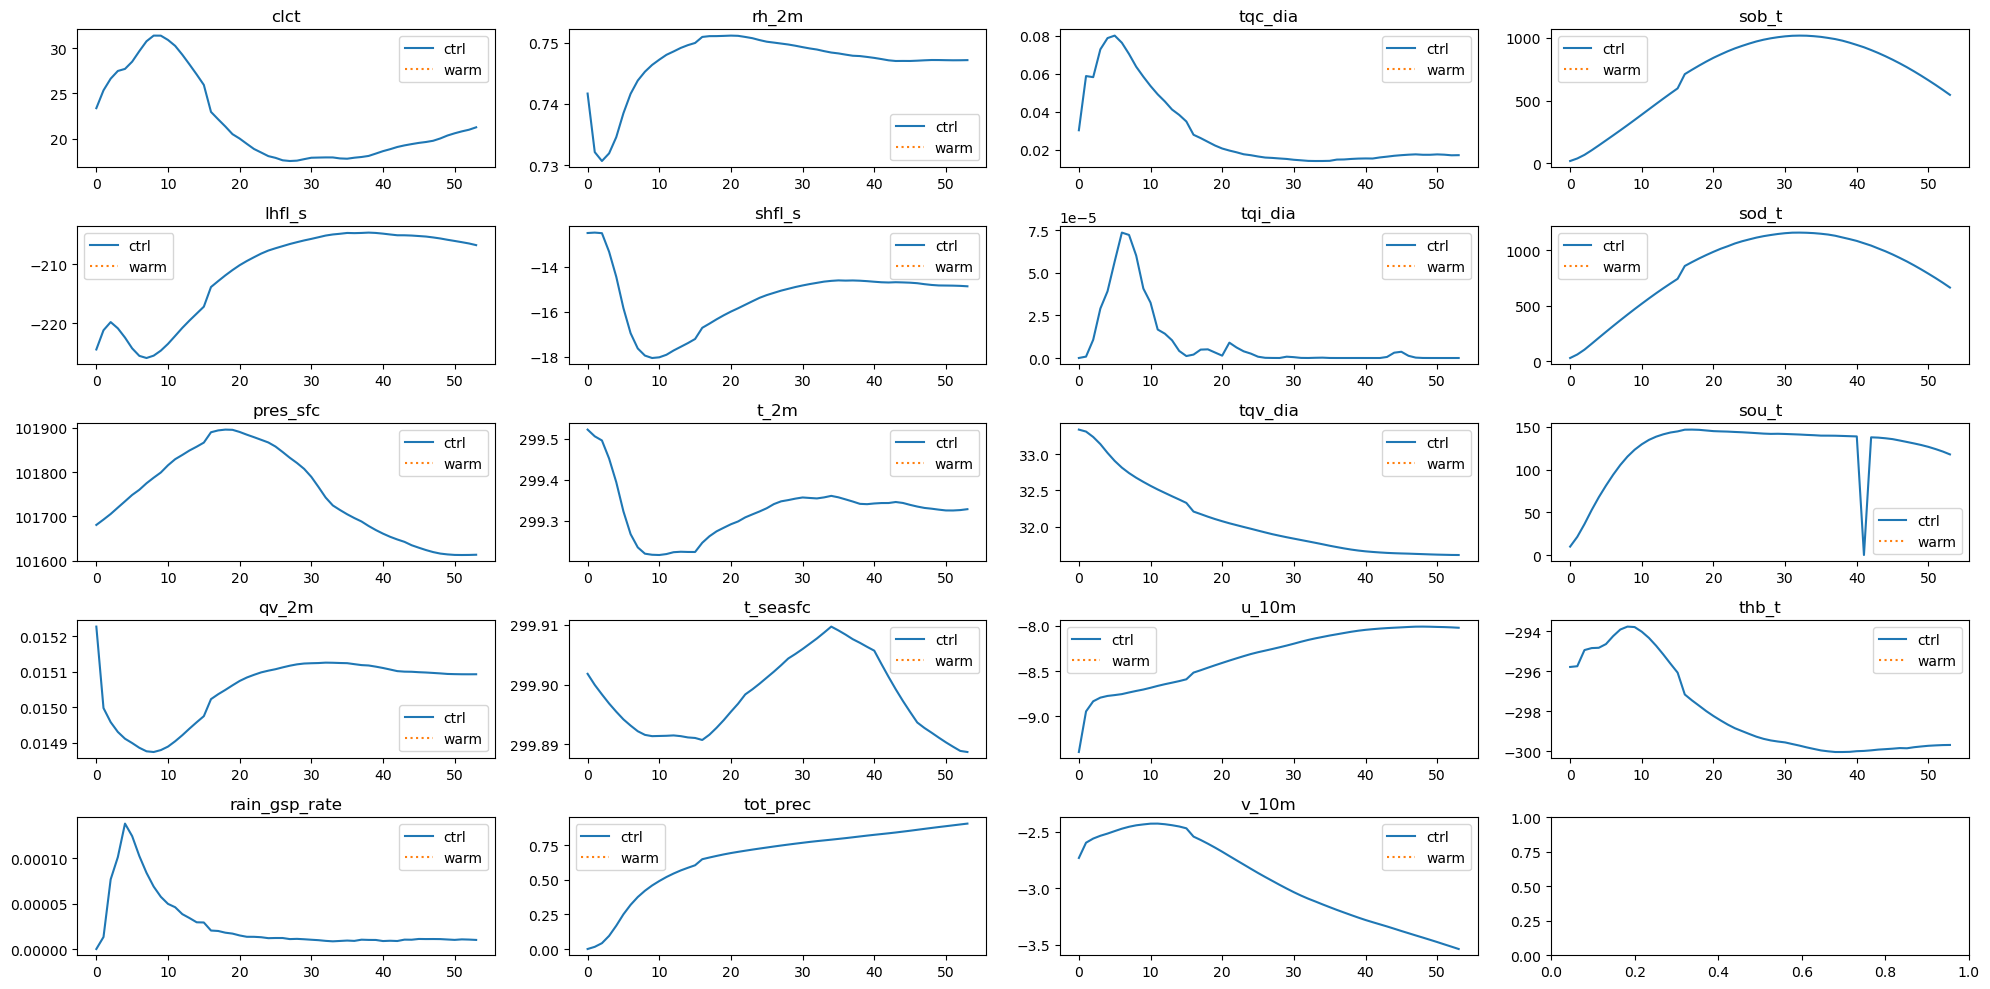

In [1]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import eurec4a
import xarray as xr    
import numpy as np
import postprocessing as pp
import matplotlib.pyplot as plt

def int_factorize(x, always_bigger=True):
    m = int(np.sqrt(x))
    n = int(x/m)
    if m*n < x and always_bigger : m += 1
    return m,n

def save_composit_timeseries(path, savename, cut_borders=True):
    files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell')
    
    files = [os.path.join(path,f) for f in os.listdir(path) if 'radiation' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, drop_dims=False)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell')
    
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

def save_matching_eurecadata(data_to_match, savename, cut_borders=True):
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.surface_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell')
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.radiation_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell').drop_vars('height_bnds').drop_dims(['height'])
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

def fig_all_domain_means(data, labels, kwargs=False, verbose=False, integral=False, mean=False):
    if not kwargs: kwargs = [dict() for d in data]
    m, n = int_factorize(len(list(data[0])))
    if verbose: print(len(list(data[0])) * len(list(data)), ' plots: ', end='')
    fig,axs = plt.subplots(m,n, figsize=(20,10))

    positions = list()
    for k in range(n):
        for i in range(m):
            positions.append((i,k)) 

    for i,var in enumerate(list(data[0])):
        ax = axs[positions[i]]
        for j, d in enumerate(data):
            if verbose: print(f'{i*(j+1) + j} {var}', end=', ')
            if mean:
                ax.axhline(0, label=None, color='black', lw=.5)
                integral = np.mean(d[var].values[d[var].values != -np.inf])
                ax.axhline(integral, label=f'mean({labels[j]}) = {integral:2f}', ls=':')
            ax.plot(d[var], label=labels[j], **kwargs[j])
        ax.set_title(var)
        ax.legend()
    if verbose: print('done')
    return fig, axs

def fixedfig_all_domain_means_warmingrun():
    warming_timeseries = 'data/moistadabatic_20230706.nc'
    control_timeseries = 'data/eurecasurface_20230706.nc'
    if not os.path.exists(warming_timeseries): 
        save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic', warming_timeseries)
    if not os.path.exists(control_timeseries):
        warm = xr.open_dataset(warming_timeseries)
        save_matching_eurecadata(warm, control_timeseries)
    
    ctrl = xr.open_dataset(control_timeseries)
    warm = xr.open_dataset(warming_timeseries)
    data = {'ctrl':ctrl, 'warm':warm}
    labels = list(data.keys())
    # labels = ['re Hauke', 're Hernan 0', 're Hernan 1', 'control']
    data = list(data.values())
    kwargs = [ dict()] * (len(data)-1) + [{'ls' : ':'}]
    # kwargs.append({'ls' : ':'})
    # kwargs = [dict(), dict(), dict(), {'ls' : ':'}]
    
    fig, axs = fig_all_domain_means(data, labels, kwargs, verbose=False)
    np.ravel(axs)[0].legend()
    fig.tight_layout()
    return fig, axs

fig, axs = fixedfig_all_domain_means_warmingrun()
fig.savefig('img/warming_run_overview.png')
fig.show()

In [27]:
path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic'
files = [os.path.join(path,f) for f in os.listdir(path) if 'radiation' in f]
files.sort()
for f in files: print(f)


/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_radiation_20200109T100000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_radiation_20200109T110000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_radiation_20200109T120000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_radiation_20200109T123000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_radiation_20200109T130000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_radiation_20200109T133000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_radiation_20200109T140000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_radiation_20200109T143000Z.nc
/work/mh1126/m300872/eureca_icon

In [7]:
data = pp.open_mfdataset_with_timedoubles(files)
data = pp.clean_surface_data(data)
data = pp.add_grid(data)
data = pp.cut_borders(data)
surface = data.mean(dim='cell')
surface

<xarray.Dataset>
Dimensions:        (time: 114)
Coordinates:
  * time           (time) datetime64[ns] 2020-01-09T10:00:00 ... 2020-01-09T1...
Data variables: (12/15)
    u_10m          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    v_10m          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    rh_2m          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    t_2m           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    qv_2m          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    t_seasfc       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...             ...
    tqc_dia        (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    tqi_dia        (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    rain_gsp_rate  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    tot_prec       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    clct           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    pres_sfc       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [8]:
surface.time.values

array(['2020-01-09T10:00:00.000000000', '2020-01-09T10:05:00.000000000',
       '2020-01-09T10:10:00.000000000', '2020-01-09T10:15:00.000000000',
       '2020-01-09T10:20:00.000000000', '2020-01-09T10:25:00.000000000',
       '2020-01-09T10:30:00.000000000', '2020-01-09T10:35:00.000000000',
       '2020-01-09T10:40:00.000000000', '2020-01-09T10:45:00.000000000',
       '2020-01-09T10:50:00.000000000', '2020-01-09T10:55:00.000000000',
       '2020-01-09T11:00:00.000000000', '2020-01-09T11:05:00.000000000',
       '2020-01-09T11:10:00.000000000', '2020-01-09T11:15:00.000000000',
       '2020-01-09T11:20:00.000000000', '2020-01-09T11:25:00.000000000',
       '2020-01-09T11:30:00.000000000', '2020-01-09T11:35:00.000000000',
       '2020-01-09T11:40:00.000000000', '2020-01-09T11:45:00.000000000',
       '2020-01-09T11:50:00.000000000', '2020-01-09T11:55:00.000000000',
       '2020-01-09T12:00:00.000000000', '2020-01-09T12:05:00.000000000',
       '2020-01-09T12:10:00.000000000', '2020-01-09

In [15]:
warming_timeseries = 'data/moistadabatic_20230706.nc'
control_timeseries = 'data/eurecasurface_20230706.nc'
if not os.path.exists(warming_timeseries): 
    save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic', warming_timeseries)
if not os.path.exists(control_timeseries):
    warm = xr.open_dataset(warming_timeseries)
    save_matching_eurecadata(warm, control_timeseries)
    
warming_timeseries = 'data/moistadabatic_20230706_b.nc'
control_timeseries = 'data/eurecasurface_20230706_b.nc'
if not os.path.exists(warming_timeseries): 
    save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic', warming_timeseries, cut_borders=False)
if not os.path.exists(control_timeseries):
    warm = xr.open_dataset(warming_timeseries)
    save_matching_eurecadata(warm, control_timeseries, cut_borders=False)

/home/m/m300872/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/m/m300872/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [56]:
import pandas as pd
import plot_utils as pu

def names_dict():
    names = dict()
    x = xr.open_dataset('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_surface_20200109T175000Z.nc').isel(time=0,ncells=0)
    for var in list(x): names[var] = x[var].long_name
    x = xr.open_dataset('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_radiation_20200109T100000Z.nc').isel(time=0,ncells=0)
    for var in list(x): names[var] = x[var].long_name
    return names

def units_dict():
    names = dict()
    x = xr.open_dataset('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_surface_20200109T175000Z.nc').isel(time=0,ncells=0)
    for var in list(x): names[var] = x[var].units
    x = xr.open_dataset('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_radiation_20200109T100000Z.nc').isel(time=0,ncells=0)
    for var in list(x): names[var] = x[var].units
    return names

def fig_all_domain_means(data, labels, kwargs=False, verbose=False, integral=False, mean=False):
    if not kwargs: kwargs = [dict() for d in data]
    m, n = int_factorize(len(list(data[0])))
    if verbose: print(len(list(data[0])) * len(list(data)), ' plots: ', end='')
    fig,axs = plt.subplots(m,n, figsize=(20,10))

    positions = list()
    for k in range(n):
        for i in range(m):
            positions.append((i,k)) 

    names = names_dict()
    units = units_dict()
    for ax, var in zip(np.ravel(axs), list(data[0])):
        for j, d in enumerate(data):
        #     if verbose: print(f'{i*(j+1) + j} {var}', end=', ')
        #     if mean:
        #         ax.axhline(0, label=None, color='black', lw=.5)
        #         integral = np.mean(d[var].values[d[var].values != -np.inf])
        #         ax.axhline(integral, label=f'mean({labels[j]}) = {integral:2f}', ls=':')
            x = [pd.to_datetime(t) for t in d['time'].values]
            x = [(t - d['time'].values[0]) /np.timedelta64(1,'h')  for t in d['time'].values]
            y = d[var].values
            ax.axhline(np.mean(y), label=labels[j], **kwargs[j], ls=':')
            ax.plot(x, y, label=labels[j], **kwargs[j])
            # pu.rotate_xticks(ax, 45)
            pu.remove_spines(ax)
        ax.set_title(names[var])
        ax.set_ylabel(units[var])
    if verbose: print('done')
    return fig, axs

def fixedfig_all_domain_means_warming_withboundaryzone():
    warming_timeseries = 'data/moistadabatic_20230706_b.nc'
    control_timeseries = 'data/eurecasurface_20230706_b.nc'
    if not os.path.exists(warming_timeseries): 
        save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic', warming_timeseries, cut_borders=False)
    if not os.path.exists(control_timeseries):
        warm = xr.open_dataset(warming_timeseries)
        save_matching_eurecadata(warm, control_timeseries, cut_borders=False)
    
    ctrl = xr.open_dataset(control_timeseries)
    warm = xr.open_dataset(warming_timeseries)
    data = {'ctrl':ctrl, 'warm':warm}
    labels = list(data.keys())
    data = list(data.values())
    kwargs = [ dict()] * (len(data)-1) + [{'color' : 'red'}]
    
    fig, axs = fig_all_domain_means(data, labels, kwargs, verbose=False)
    # np.ravel(axs)[0].legend()
    fig.tight_layout()
    return fig, axs

fig, axs = fixedfig_all_domain_means_warming_withboundaryzone()
fig.savefig('img/warming_run_overview.svg')
fig.show()

In [42]:
dir(pu)

['Image',
 'ImageDraw',
 'PatchCollection',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'add_map_view',
 'add_rectangles',
 'adjust_spines',
 'bipolar_vminmax',
 'ccrs',
 'center_around_zero',
 'cfeature',
 'gif_from_image_list',
 'icon2datetime',
 'image2mpeg',
 'int2month',
 'month2int',
 'non_redundant_legend',
 'np',
 'os',
 'plt',
 'provide_fig',
 'remove_spines',
 'remove_ticks',
 'rotate_xticks',
 'savefig',
 'xr']

In [53]:
def names_dict():
    names = dict()
    x = xr.open_dataset('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_surface_20200109T175000Z.nc').isel(time=0,ncells=0)
    for var in list(x): names[var] = x[var].long_name
    x = xr.open_dataset('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_radiation_20200109T100000Z.nc').isel(time=0,ncells=0)
    for var in list(x): names[var] = x[var].long_name
    return names

x = xr.open_dataset('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_surface_20200109T175000Z.nc').isel(time=0,ncells=0)
x['tqv_dia'].attrs

{'standard_name': 'tqv_dia',
 'long_name': 'total column integrated water vapour (diagnostic)',
 'units': 'kg m**-2',
 'param': '214.1.0',
 'CDI_grid_type': 'unstructured',
 'number_of_grid_in_reference': 1}

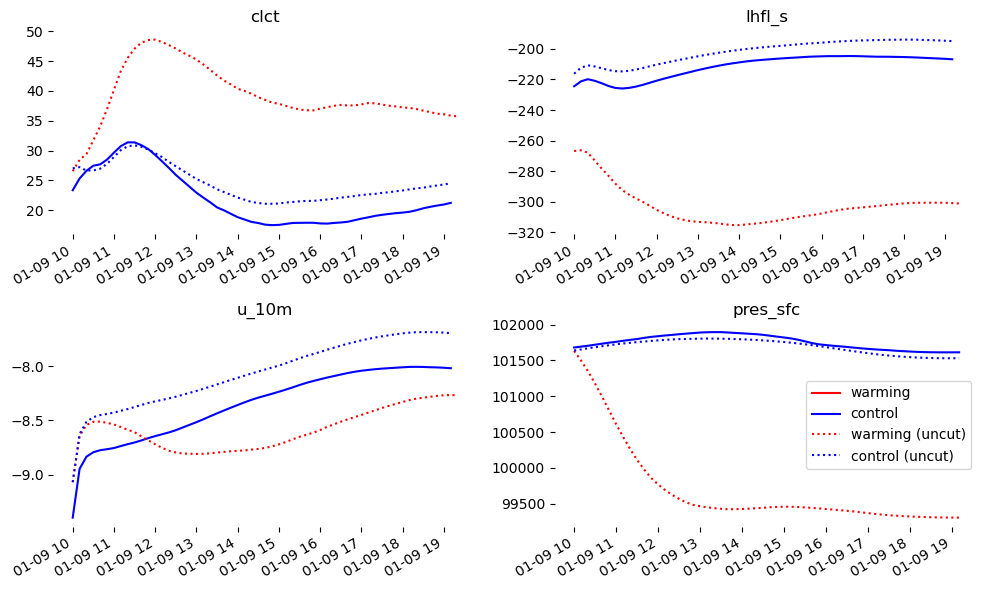

In [4]:
import plot_utils as pu

def ax_domain_means_warmingrun(ax, var):
    ctrl = xr.open_dataset('data/eurecasurface_20230706.nc')
    warm = xr.open_dataset('data/moistadabatic_20230706.nc')
    ax.plot(warm[var].time, warm[var], label='warming', color='red')
    ax.plot(ctrl[var].time, ctrl[var], label='control', color='blue')
    ctrl = xr.open_dataset('data/eurecasurface_20230706_b.nc')
    warm = xr.open_dataset('data/moistadabatic_20230706_b.nc')
    ax.plot(warm[var].time, warm[var], label='warming (uncut)', ls=':', color='red')
    ax.plot(ctrl[var].time, ctrl[var], label='control (uncut)', ls=':', color='blue')
    
    ax = pu.rotate_xticks(ax)
    ax = pu.remove_spines(ax)
    ax.set_xlabel
    axs = ax
    # ax.legend()
    ax.set_title(var)
    return ax

fig, axs = plt.subplots(2,2,figsize=(10,6))
varis = ['clct', 'lhfl_s', 'u_10m', 'pres_sfc']
for ax, var in zip(np.ravel(axs), varis):
    ax = ax_domain_means_warmingrun(ax, var)
np.ravel(axs)[-1].legend()
fig.tight_layout()
fig.savefig(f'img/{var}_overview.png')
fig.show()

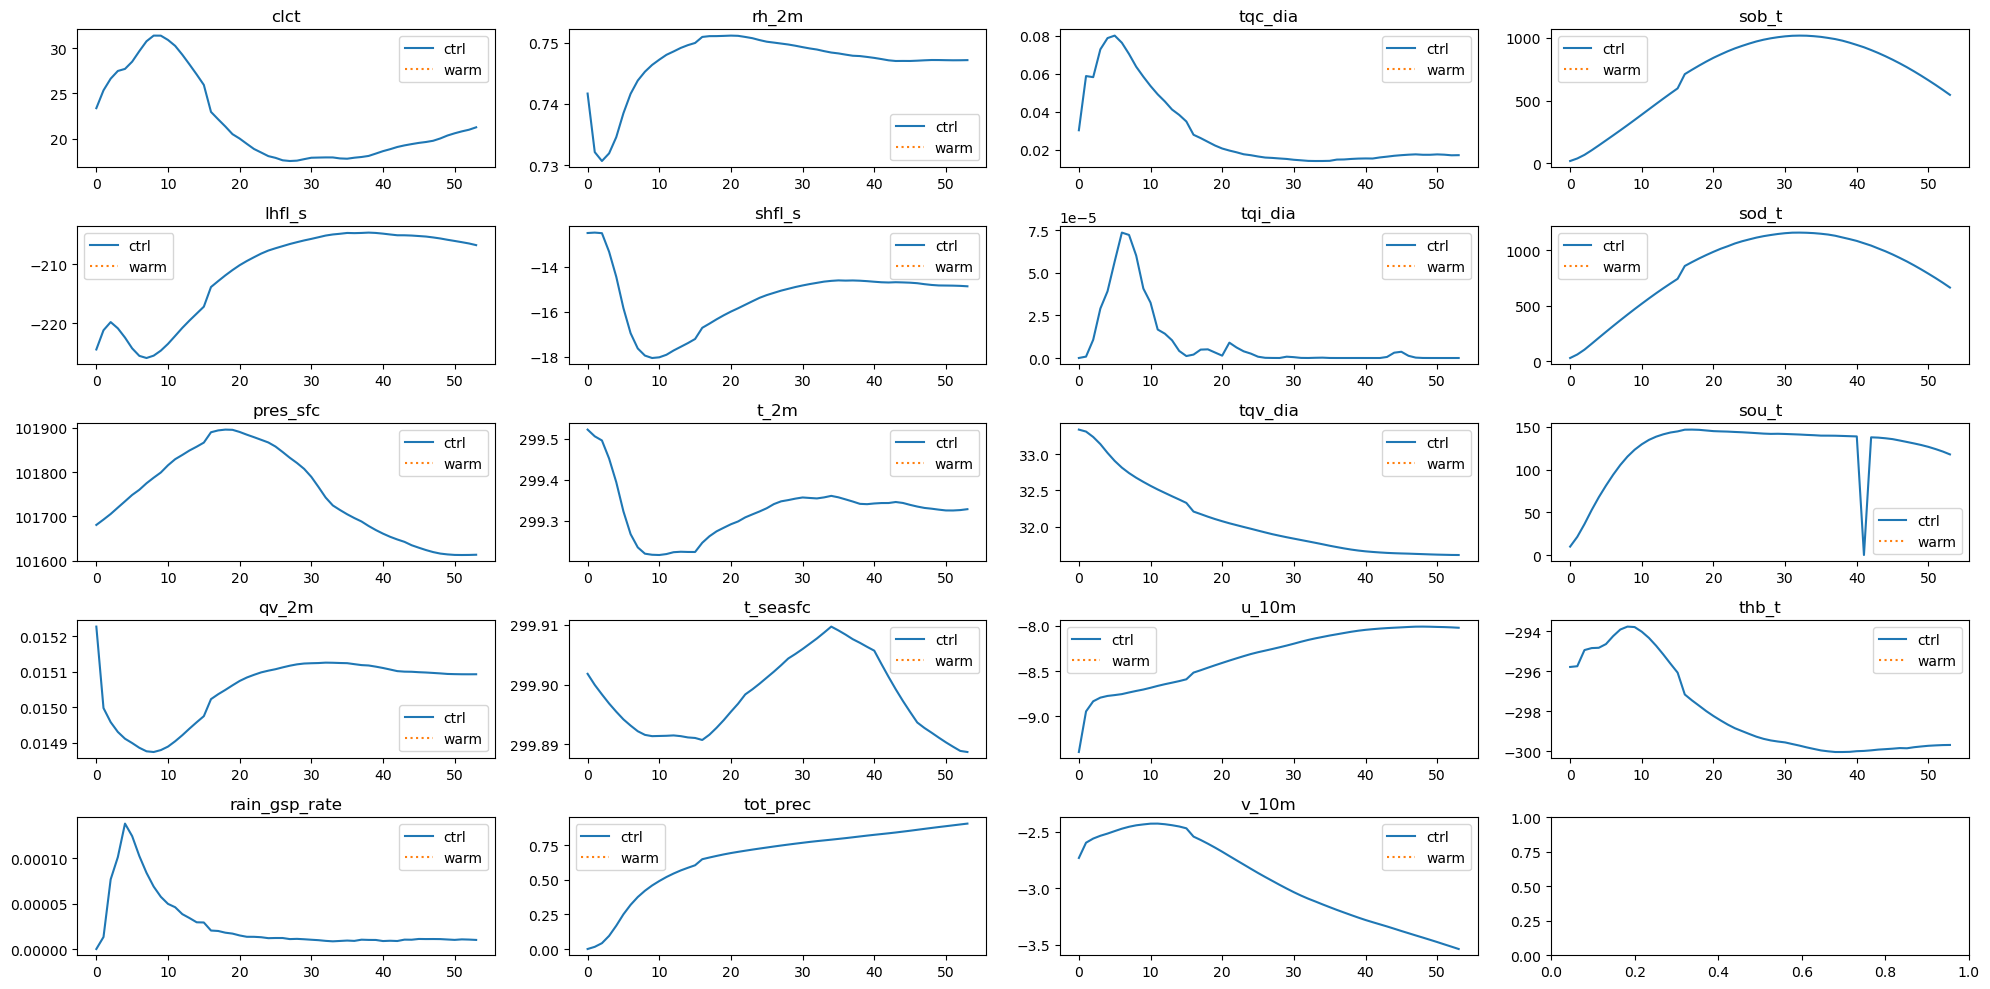

In [14]:
def fig_all_domain_means(data, labels, kwargs=False, verbose=False, integral=False, mean=False):
    if not kwargs: kwargs = [dict() for d in data]
    m, n = int_factorize(len(list(data[0])))
    if verbose: print(len(list(data[0])) * len(list(data)), ' plots: ', end='')
    fig,axs = plt.subplots(m,n, figsize=(20,10))

    positions = list()
    for k in range(n):
        for i in range(m):
            positions.append((i,k)) 

    for i,var in enumerate(list(data[0])):
        ax = axs[positions[i]]
        for j, d in enumerate(data):
            if verbose: print(f'{i*(j+1) + j} {var}', end=', ')
            if mean:
                ax.axhline(0, label=None, color='black', lw=.5)
                integral = np.mean(d[var].values[d[var].values != -np.inf])
                ax.axhline(integral, label=f'mean({labels[j]}) = {integral:2f}', ls=':')
            ax.plot(d[var], label=labels[j], **kwargs[j])
        ax.set_title(var)
        ax.legend()
    if verbose: print('done')
    return fig, axs

def fixedfig_all_domain_means_warming_withboundaryzone():
    warming_timeseries = 'data/moistadabatic_20230706.nc'
    control_timeseries = 'data/eurecasurface_20230706.nc'
    if not os.path.exists(warming_timeseries): 
        save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic', warming_timeseries, cut_borders=False)
    if not os.path.exists(control_timeseries):
        warm = xr.open_dataset(warming_timeseries)
        save_matching_eurecadata(warm, control_timeseries, cut_borders=False)
    
    ctrl = xr.open_dataset(control_timeseries)
    warm = xr.open_dataset(warming_timeseries)
    data = {'ctrl':ctrl, 'warm':warm}
    labels = list(data.keys())
    data = list(data.values())
    kwargs = [ dict()] * (len(data)-1) + [{'ls' : ':'}]
    
    fig, axs = fig_all_domain_means(data, labels, kwargs, verbose=False)
    np.ravel(axs)[0].legend()
    fig.tight_layout()
    return fig, axs

fig, axs = fixedfig_all_domain_means_warming_withboundaryzone()
fig.savefig('img/warming_run_overview.png')
fig.show()